SCA_AGENT_MEMORY_BEFORE: 1452752896


AnnData object with n_obs × n_vars = 39516 × 33538
    obs: 'label', 'group', 'source_file', 'batch'
    var: 'gene_ids', 'feature_types'

Metadata keys: Index(['label', 'group', 'source_file', 'batch'], dtype='object')

Variable gene keys: Index(['gene_ids', 'feature_types'], dtype='object')

Shape of the data: (39516, 33538)


Set of variables used:
 - n_pcs: 40
 - n_neighbors: 10
 - resolution: 0.7



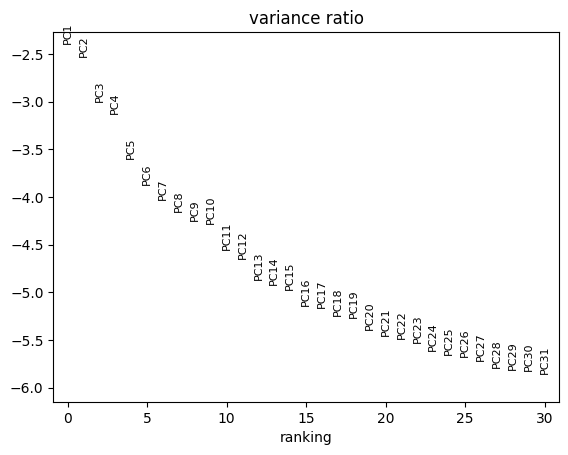

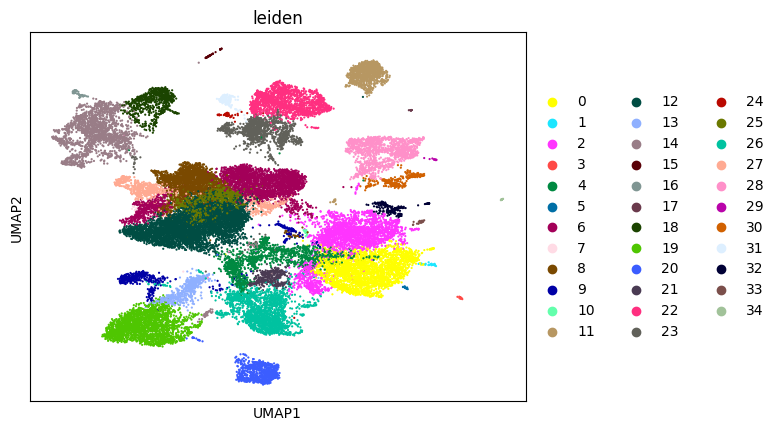

Ranking genes grouped by 'leiden' using method 'wilcoxon'...



Top 5 marker genes per 'leiden' cluster:
Cluster 0: PERP, KRT19, KRT5, TACSTD2, KRT15
Cluster 1: S100P, KRT19, SCGB1A1, PTGDS, PHLDA2
Cluster 2: CLDN4, ELF3, WFDC2, RARRES1, KRT19
Cluster 3: KRT13, TACSTD2, CLDN5, CLDN4, LCN2
Cluster 4: MT-ND1, MT-ND4, MT-CO1, MT-CO2, MT-ND2
Cluster 5: MSLN, MDK, KRT19, WFDC2, ADIRF
Cluster 6: CCL5, CCL4, CD8A, LINC01871, CD7
Cluster 7: NPY, MT-ND4, MT-ND2, IL7R, MT-CO2
Cluster 8: LTB, TRBC2, IL7R, BTG1, CXCR4
Cluster 9: NKX3-1, KLK4, SORD, MSMB, KLK2
Cluster 10: HBA1, HBA2, HBB, NEAT1, ELF3
Cluster 11: MS4A1, CD79A, CD74, HLA-DRA, CD83
Cluster 12: MALAT1, MT-CO1, MT-ND2, MT-ND1, BTG1
Cluster 13: MT-CO2, MT-ND4, MT-CO1, NPY, MT-ND2
Cluster 14: HLA-DRA, CD74, HLA-DPA1, HLA-DPB1, HLA-DRB1
Cluster 15: OLFM4, SCGB3A1, LCN2, RARRES1, PIGR
Cluster 16: HLA-DRB1, HLA-DQA1, HLA-DRA, HLA-DPB1, LYZ
Cluster 17: GPR183, LYZ, HLA-DQA1, HLA-DRB1, APOC1
Cluster 18: S100A9, LYZ, CTSS, SOD2, IL1B
Cluster 19: NPY, PCA3, GOLM1, FOLH1, SPOCK1
Cluster 20: TPSAB1, CPA3, TPS

In [3]:
%reset -f
import psutil
process = psutil.Process()
print(f'SCA_AGENT_MEMORY_BEFORE: {process.memory_info().rss}')
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils_agent import (
    filter_cells,
    normalize_log_transform,
    filter_lowqc_cells,
    save_high_var_gene,
    pca_and_plot_umap,
    get_top_marker_genes
)

# Load the source data
adata = sc.read_h5ad('template_code/tumor_adata.h5ad')

# Quick inspection - inspecting the structure of the data
def quick_inspect(adata):
    print(adata)
    print("\nMetadata keys:", adata.obs.keys())
    print("\nVariable gene keys:", adata.var.keys())
    print("\nShape of the data:", adata.shape)
    
quick_inspect(adata)

# Step-by-step processing
# Step 1: Initial quality control and filtering
filter_cells(adata, min_cells=3, min_genes=200, max_genes=50000)

# Step 2: Normalize and log-transform
normalize_log_transform(adata)

# Step 3: Filter low-quality cells based on mitochondrial content and gene counts
adata = filter_lowqc_cells(adata, pct_counts_mt_upbound=10)

# Step 4: Save high variable genes for downstream dimensionality reduction
adata = save_high_var_gene(adata, n_top_genes=4000)

# Step 5: Perform PCA and compute UMAP
pca_and_plot_umap(adata, n_pcs=40, n_neighbors=10, resolution=0.7)

# Step 6: Get top marker genes for each cluster
get_top_marker_genes(adata, groupby='leiden', method='wilcoxon', top_n=5)

# Save the preprocessed AnnData object locally
adata.write('adata_preprocessed.h5ad')

print("Preprocessing complete. `adata` has been saved as adata_preprocessed.h5ad.")
print(f'SCA_AGENT_MEMORY_AFTER: {process.memory_info().rss}')


In [4]:
%reset -f
import psutil
process = psutil.Process()
print(f'SCA_AGENT_MEMORY_BEFORE: {process.memory_info().rss}')
# Import necessary modules
import scanpy as sc
import pandas as pd
from utils_agent import assign_cell_categories, quick_inspect_adata

# Load the preprocessed AnnData object
adata = sc.read_h5ad("adata_preprocessed.h5ad")

# Quick inspection of the AnnData object
quick_inspect_adata(adata)

# Based on the biological context and the DEG results provided,
# map each cluster to a cell type based on distinguishing marker genes:
cluster_to_category = {
    "0": "Basal Epithelial Cells",  # KRT5, KRT15, PERP, KRT19
    "1": "Luminal Progenitor Cells",  # KRT19, SCGB1A1, S100P
    "2": "Luminal Differentiated Cells",  # CLDN4, ELF3, KRT19
    "3": "Basal Epithelial Cells",  # KRT13, TACSTD2
    "4": "Mitochondrial-rich Cells",  # MT-ND1, MT-ND4, MT-CO1
    "5": "Tumor-derived Luminal Cells",  # MSLN, MDK, KRT19
    "6": "T Cells (Cytotoxic)",  # CD8A, CCL5, CCL4
    "7": "NK Cells",  # NPY, IL7R
    "8": "Naive/Memory T Cells",  # LTB, CXCR4, IL7R
    "9": "Prostate Secretory Cells",  # NKX3-1, KLK4, KLK2
    "10": "Erythroid Cells",  # HBA1, HBA2, HBB
    "11": "B Cells",  # MS4A1, CD79A, CD74
    "12": "Mitochondrial-rich Cells",  # MT-CO1, MT-ND1
    "13": "Mitochondrial-rich Cells",  # MT-ND4, MT-CO2
    "14": "Dendritic Cells / APC",  # HLA-DRA, CD74
    "15": "Goblet-like Secretory Cells",  # OLFM4, LCN2
    "16": "Dendritic Cells / APC",  # HLA-DRB1, HLA-DQA1
    "17": "Monocytes",  # LYZ, APOC1
    "18": "Myeloid Cells",  # S100A9, LYZ
    "19": "NPY-expressing Epithelial Cells",  # NPY, PCA3
    "20": "Mast Cells",  # TPSAB1, CPA3
    "21": "Tumor-derived Luminal Cells",  # AGR2, NKX3-1
    "22": "Endothelial Cells",  # VWF, SPARCL1
    "23": "Endothelial-Mesenchymal Transitioning",  # SPARCL1, IGFBP7
    "24": "Myofibroblasts / Mesenchymal Cells",  # SPARC, IGFBP7
    "25": "Cytotoxic T Cells",  # GZMK, GZMA, CCL5
    "26": "Prostate Secretory Cells",  # KLK3, KLK2
    "27": "Natural Killer Cells",  # NKG7, GNLY
    "28": "Pericytes / Smooth Muscle Cells",  # CALD1, TAGLN
    "29": "Smooth Muscle Cells",  # TAGLN, MYL9
    "30": "Stromal Fibroblasts",  # DCN, FBLN1
    "31": "Endothelial Cells",  # CLEC14A, CLDN5
    "32": "Secretory Goblet-like Cells",  # LCN2, PIGR
    "33": "Pancreatic-like Epithelial Cells",  # CXCL1, LTF
    "34": "Mixed Epithelial Cells"  # KRT13, KRT19
}

# Assign cell categories based on the clusters
adata = assign_cell_categories(adata, cluster_to_category)

# Crosstab to analyze the distribution of cell types across groups
cell_category_group_distribution = pd.crosstab(adata.obs["cell_category"], adata.obs["group"])
print("\nCell category distribution across groups:")
print(cell_category_group_distribution)

# Save the annotated AnnData object to file
adata.write("adata_annotated.h5ad")
print(f'SCA_AGENT_MEMORY_AFTER: {process.memory_info().rss}')


SCA_AGENT_MEMORY_BEFORE: 1310179328


Cells: 33717, Genes: 4000
Available layers: []
Obsm keys: ['X_pca', 'X_umap']

=== obs metadata (for visualization) ===
[CAT] label (8 categories) → ['P3t', 'P2t', 'P1n', 'P4n', 'P3n', 'P4t', 'P2n', 'P1t']
[CAT] group (2 categories) → ['Tumor', 'Normal']
[CAT] source_file (8 categories) → ['GSM5793831_P3t', 'GSM5793829_P2t', 'GSM5793824_P1n', 'GSM5793827_P4n', 'GSM5793826_P3n', 'GSM5793832_P4t', 'GSM5793825_P2n', 'GSM5793828_P1t']
[CAT] batch (8 categories) → ['0', '1', '2', '3', '4', '5', '6', '7']
[NUM] n_genes (range=201.00 ~ 12207.00)
[NUM] n_genes_by_counts (range=201.00 ~ 12207.00)
[NUM] log1p_n_genes_by_counts (range=5.31 ~ 9.41)
[NUM] total_counts (range=175.21 ~ 4418.91)
[NUM] log1p_total_counts (range=5.17 ~ 8.39)
[NUM] total_counts_mt (range=0.00 ~ 76.86)
[NUM] log1p_total_counts_mt (range=0.00 ~ 4.35)
[NUM] pct_counts_mt (range=0.00 ~ 10.00)
[CAT] leiden (35 categories) → ['0', '6', '13', '19', '9', '14', '22', '7'] ...

Cell category distribution across groups:
group      

In [5]:
%reset -f
import psutil
process = psutil.Process()
print(f'SCA_AGENT_MEMORY_BEFORE: {process.memory_info().rss}')
import anndata as an
from utils_agent import get_gene_by_disease

# Step 1: Load the annotated single-cell data
adata = an.read_h5ad("adata_annotated.h5ad")

# Step 2: Identify disease subtypes to study
# Given biological context, treat the "Tumor" group as the disease subtype
to_study = ["Tumor"]

# Control group in the dataset is labeled as "Normal"
control_type = "Normal"

# Create a list of cell types to analyze based on meaningful context from Step 2 result
# Focus on cell categories with substantial proportions in "Tumor" for further analysis
cell_types_to_analyze = [
    "Basal Epithelial Cells",
    "Dendritic Cells / APC",
    "Mitochondrial-rich Cells",
    "Prostate Secretory Cells",
    "Luminal Differentiated Cells",
    "T Cells (Cytotoxic)",
    "NK Cells",
    "Naive/Memory T Cells",
    "NPY-expressing Epithelial Cells",
]

# Save individual copies of adata with control and disease subtypes
sub_adatas = [
    adata[adata.obs['group'].isin([control_type, group])].copy() for group in to_study
]

# Step 3: Obtain the potential gene sets for each disease type
gene_sets_by_disease = {}
n_genes_to_use = 300  # Adjust based on dataset information and analysis requirements

for curr_adata, curr_group in zip(sub_adatas, to_study):
    # Generate potential gene sets using the `get_gene_by_disease` function
    gene_sets = get_gene_by_disease(
        adata,
        curr_adata,
        curr_group,
        cell_types_to_analyze,
        n_genes=n_genes_to_use,
        control_type=control_type,
    )
    # Save the results for the current disease group
    gene_sets_by_disease[curr_group] = gene_sets

# Display the obtained gene sets for each disease subtype
print("Gene sets by disease type:")
for group, gene_set in gene_sets_by_disease.items():
    print(f"Disease Group: {group}, Gene Set: {gene_set}")
print(f'SCA_AGENT_MEMORY_AFTER: {process.memory_info().rss}')


SCA_AGENT_MEMORY_BEFORE: 1325596672


Current Group:Tumor
{'MT1X': {'DEG': [{'cell_type': 'Basal Epithelial Cells', 'pval': 2.0101882778648324e-37, 'score': 12.784161567687988, 'logFC': 1.279355764389038, 'pval_adj': 1.4986826548755937e-34}], 'TF enrichment': [{'Term': 'Mineral absorption', 'adj_pval': 0.0062233188055383}]}, 'CALD1': {'DEG': [{'cell_type': 'Basal Epithelial Cells', 'pval': 3.3005089285207414e-29, 'score': 11.218709945678711, 'logFC': 1.1983420848846436, 'pval_adj': 7.334464285601648e-27}, {'cell_type': 'Prostate Secretory Cells', 'pval': 2.426004136945111e-13, 'score': 7.322937488555908, 'logFC': 0.47246187925338745, 'pval_adj': 3.130327918638853e-11}], 'TF enrichment': [{'Term': 'Vascular smooth muscle contraction', 'adj_pval': 0.3312592132165087}]}, 'APOC1': {'DEG': [{'cell_type': 'Dendritic Cells / APC', 'pval': 1.946778286056674e-43, 'score': 13.819402694702148, 'logFC': 2.6020450592041016, 'pval_adj': 7.787113144226696e-40}], 'TF enrichment': [{'Term': 'Cholesterol metabolism', 'adj_pval': 0.331259213